# Project: Dense Prediction: Monocular Depth Estimation and Semantic Segmentation

<img src='https://i.imgur.com/I2rSgxd.png' width=200> <img src='https://i.imgur.com/1oP2EIg.png' width=200>

This assignment is worth 80 points.
The breakdown is as follows:

**Part 1 Depth Estimation: 55**

    - Dilate Backbone: 10

    - Create hook for extracting last layer: 5

    - Create ASPP module : 5

    - Create hook for intermediate features: 5
    
    - Implement Separable conv:5 

    - Correct implementation+logging: 5

    -     

    - Loss function: 5

    -
    
    - Training/evaluation: 15
    

**Part 2 Semantic Segmentation: 25**

    - Dataloader: 10

    - Loss function: 5
    
    - Training/evaluation: 10


For every architecture, and every dataset - so 4 combinations please save the output as output by our training script of your best training in a file. And present this file during evaluation.


This is a very compute heavy project so we would advise you to start early. Both the depth estimation part and semantic segmentation part use the same model, so you can tackle building your model in either. The tradeoff is that Depth estimation is a larger dataset and takes a lot of time to train. On the other hand the segmentation dataset is a lot smaller but requires writing your own code to load the data which might prevent you from beginning developing your model.

2 hours per run is not unheard of for the depth estimation model so plan accordingly.

## Again, please begin early so that you can fix your problems and get enough time to train. In previous iterations of the course, people often could not implement a lot of code if they began late.

# Part 1
## Introduction

- In this part of the project, you are tasked to create a model that **estimates depth from a single input image**. The input is an RGB image and the output is a single channel dense depth map where each pixel is the estimated distance from the 'camera sensor' to an object in the scene in real world units (e.g. in meters). Depth from a single image is a fundemental vision task with many useful applications including scene understanding and reconstruction.

- You are to develop a convolutional neural network (CNN) that formulates the problem as a regression of the depth map from a single RGB image. 

- In this section, we provide all the source code needed for loading and evaluating your model.  You will reuse the model in the next section

- Please read the two papers [DeeplabV3](https://arxiv.org/pdf/1706.05587.pdf) and [DeeplabV3+](https://arxiv.org/pdf/1802.02611.pdf), and familiarize yourself with the notion of _output stride_ and _dilation_ as discussed in the paper.

- Your task in this section is to modify the script in order to:
    - Define two models [DeeplabV3](https://arxiv.org/pdf/1706.05587.pdf) and [DeeplabV3+](https://arxiv.org/pdf/1802.02611.pdf) that take in an RGB image and output single channel depth map. **[35 points]**
    - Define an approprate loss function. **[5 points]**
    - Tune the model to achieve an RMSE of **0.035** or less on the given validation set. **[15 points]**


<hr/>

**Note**: Make sure that your Collab notebook is a GPU instance. Also, the first time you run the training, the instance might crash for exceeding the allocated memory. This is expected behaviour, especially with large batch sizes. Collab will suggest restarting the session and providing instances with larger memory sizes.

**Note**: This project is more open-ended than the previous projects. Multiple solutions can be considered _correct_. As there already exist implementations of various deep networks for this task on the interwebs, **plagiarism will NOT be tolerated**. Your code will be judged for similarity against code available online and other students' code. You are expected to justify every design decision when your project is being evaluated.

**Note**: The networks you will design/implement will be much larger than what you have previously designed. Please bring hardware concerns to the attention of the [TA](mailto:wamiq.para@kaust.edu.sa). You will need to begin early to test out new ideas/hyperparameters and training will take much longer. Best of luck!

<hr/>

## Downloading Data

Please download the zip files from the below address manually and extract them in the same directory as the notebook.

[Link](https://drive.google.com/drive/folders/1v4tFxMJPZ35yOK6bCpptvybR2PEEd3Bn?usp=sharing)

## Hyperparameters

You are supposed to change the batch_size and learning_rate from their default value.

# TODO:
Please modify these parameters: epochs, batch size etc to get good performance. 
The defaults are not good. 

You will need to tune these to achieve decent performance. You can look at the Deeplab papers for a good learning rate to start out with, and then experiment to achieve good performance.


The batch size is constrained by your GPU memory. Read the paper to see what impact batch_size has on performance 

In [10]:
import os
import gc
import time
import datetime
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet34
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Change this to reflect 

epochs = 30
batch_size = 4
learning_rate = 1
workers = 1 # The number of parallel processes used to read data
gpu_id = [0] # only modify if you machine has more than one GPU card

## Data Loader (no tasks required)

In [11]:
if __name__ == '__main__':
    from loaders import prep_loaders
    train_loader, valid_loader = prep_loaders('UnrealData256', batch_size=batch_size, workers=workers)

Dataset size (num. batches) 6339 130


## Sanity check 

Populating the interactive namespace from numpy and matplotlib


/home/parawr/anaconda3/envs/alles/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 128, 128])


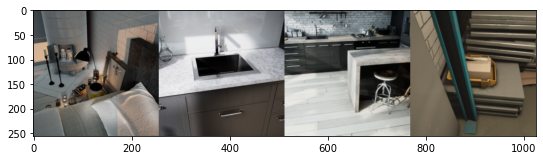

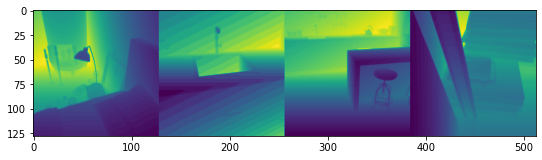

In [12]:
# Examine training data
%pylab inline
import torchvision
sample = iter(train_loader).next()
print(sample['image'].shape, sample['depth'].shape)
figure(figsize=(9,9)); imshow(torchvision.utils.make_grid(sample['image'], padding=0).permute((1, 2, 0)))
figure(figsize=(9,9)); imshow(torchvision.utils.make_grid(sample['depth'], padding=0, normalize=True, scale_each=True).permute((1, 2, 0))[:,:,0])

# TODO:
Gain some familiarity with the dataset.

Answer these qestions

What is the size of the input RBG image?

What is the size of the output labels?

## Model [35 points]

Define your model here. 

The current model is going to run not be able to compute depth.
The first task should be to get the output of the network to the same size as the depth maps.

This can be done by removing the classification heads from the backbone network.

Some key points to keep in mind during this task:
1. Get familiar with hooks. Read something about them [here](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=forward%20hook#torch.nn.Module.register_forward_hook). 
2. You can google around to find how to use hooks.
3. Learn how to iterate/loop over the submodules of a network. Key functions to note are `nn.Module.children`, `nn.Module.modules`, and similar functions. Choose one that will let you know the name of the layer/module as well. Beware `nn.Sequential` behave differently than `nn.Module` in some cases. You will need this to modify the layers of the Resnet model
4. You should define your own module for the depthwise separable convolution

#### More pointers
1. We use Resnet34 as the backbone. Know the architecture well by printing it out. 
2. You will need knowledge about the number of channels, strides etc to create a proper network.
3. The output_stride of the ResNet model is going to be 16. This means we modify one strided convolution.
4. Both papers show that using pretrained weights for the backbone/encoder improves performance, so we want to use pretrained weights.
5. In order to use pretrained weights, and change the output stride, we modify the attributes of the layers of the network. DO NOT replace pretrained layers. That will lead to worse performance and you will lose points

#### More more pointers
1. If you set up the network properly, you should see nice results in about 20 epochs.
2. Note that the deeplab series models are actually created for semantic segmentation. We will perform that task in the second part of the assignment

In [13]:
class DepthWiseSeparableConv(nn.Module):
    def __init__(in_channels, out_channels, kernel_size, stride=1, padding=0):
        # You change change the input arguments if your want
        super().__init__()
        # TODO

    def forward(self, x):
        # TODO
        return x


class Model(nn.Module):
    def __init__(self,
                output_stride=16,
                atrous_conv_rate=2,
                feat_spatial_size=32,
                dilation_rates=[3, 6, 9],
                use_decoder=True,
                backbone_feats_dim=512,
                decoder_feats_dim=256,
                num_classes=1):
        super(Model, self).__init__()

        self.output_stride = output_stride 
        self.atrous_rate_conv = atrous_conv_rate
        self.feat_spatial_size = feat_spatial_size  # This is the height and width of extracted features
        self.dilation_rates = dilation_rates # The dilation rates for the ASPP module
        self.use_decoder = use_decoder # if False, use DeeplabV3 else DeeplabV3+
        self.backbone_feats_dim = backbone_feats_dim # This is what the 
        self.decoder_feats_dim = decoder_feats_dim # Use this consistently after the ASPP
        self.num_classes = num_classes # Use to control the number of channels in the output

        
        self.backbone = resnet34(pretrained=True)
        # Task 1.1: Setup the correct Resnet34 network.
        # This means taking an instantiated network and replacing stride 2 on the last layer
        # with stride 1 and dilation 2.
        # TODO

        # Task 1.2 Save the last features of the backbone
        # We have to do this as forward of our model includes a flatten statement.
        # The hook should save the output of the last layer in to a dict, whose keys are the 
        # device of the output tensor and the value is the output tensor itself.
        # BONUS 5 points : Instead of doing a forward hook, show how to work with the flattened tensor that the Resnet outputs.
        self.last_feats = dict()
        self.last_feat_hook_handle = self._set_last_feat_hook()

        # Task 1.3 Add ASPP module.
        self.aspp_module = self._get_aspp_module(self.dilation_rates)
        
        if not use_decoder:
            # Task 1 is almost complete
            self.decoder = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        else:
            # Task 2 starts here
            # Extract intermediate features
            self.intermediate_feats = dict()
            
            # Task 2.1 Setup a forward hook to retrieve intermediate features 
            # in self.intermediate_feats during the forward pass. The intermediate features should have 4x
            # downsampling. Note that there are two places to extract such features -ie at the end of two layers
            # you should have features with the same spatial size (NOT channels). Use features from deeper in the mode
            # ie features obtained after more convolutions
            self.fwd_hook_handle =  self._set_fwd_hook()

            # Task 2.2 Setup a DeeplabV3+ style decoder with separable convs
            self.decoder = self._get_deeplabv3_decoder() 

            self.feat_upsampler = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
            self.logits_upsampler = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)


        # TODO: This is different for DeeplabV3 and V3+. Make sure to look the forward function to see
        # how many channels we need here
        self.logits_generator = nn.Sequential(
                                       nn.Identity())

    def _set_last_feat_hook(self):
        # TODO
        return None


    def _get_aspp_module(self, dilation_rates):
        # TODO
        # Return 3 dilated convs+activation modules depending on the dilation_rates 
        # plus a 1x1 conv and  global averaging module
        list_of_modules =  [nn.Identity()] 
        list_of_modules += [nn.Identity() for _ in dilation_rates]
        list_of_modules += [self._get_global_avg_module()]

        return nn.ModuleList(list_of_modules)

    def _get_global_avg_module(self):
        # TODO
        # Hint: use nn.Sequential
        # Hint: you might need to use self.feat_spatial_size
        return nn.Identity()
    
    def _set_fwd_hook(self):
        # TODO
        return None

    def _get_deeplabv3_decoder(self):
        # TODO
        # This is two layers of depthwise-separable convolutions. You will have to implement the separable 
        # convs by yourself

        return nn.Identity()

    
    def forward(self, x):
        # Extract features
        _ = self.backbone(x)
        feats = self.last_feats[x.device]

        # Perfrom multiscale feature extraction on features
        aspp_feats = []
        for m in self.aspp_module:
            aspp_feats.append(m(feats))

        feats = torch.cat(aspp_feats, dim=1)

        if not self.use_decoder:
            return self.decoder(self.logits_generator(feats))
        else:
            # the hook should save intermediate features in self.intermediate_features
            feats = self.feat_upsampler(feats)
            feats = torch.cat([feats, self.intermediate_feats[x.device]], dim=1)
            feats = self.decoder(feats)
            logits =  self.logits_generator(feats)
            return self.logits_upsampler(logits)

    
def create_model_gpu(output_stride=16,
                atrous_conv_rate=2,
                feat_spatial_size=32,
                dilation_rates=[3, 6, 9],
                use_decoder=True,
                backbone_feats_dim=512,
                decoder_feats_dim=256,
                num_classes=1):
                
    model = Model(output_stride=output_stride,
                atrous_conv_rate=atrous_conv_rate,
                feat_spatial_size=feat_spatial_size,
                dilation_rates=dilation_rates,
                use_decoder=use_decoder,
                backbone_feats_dim=backbone_feats_dim,
                decoder_feats_dim=decoder_feats_dim,
                num_classes=num_classes)
    model = model.cuda()
    model = nn.DataParallel(model, device_ids=[g for g in gpu_id])
    return model

model = create_model_gpu(output_stride=16,
                atrous_conv_rate=2,
                feat_spatial_size=32,
                dilation_rates=[3, 6, 9],
                use_decoder=True,
                backbone_feats_dim=512,
                decoder_feats_dim=256,
                num_classes=1)
print('Ready to train.')

#model.load_state_dict(torch.load('trained_model.pkl'))

Ready to train.


## Loss Function [5 points]

Define a loss function that is suitable for the dense regression task.
Why will the current loss not work? Submit the answer in the notebook.

In [5]:
import torch
from math import exp
import torch.nn.functional as F


def loss_fn(pred_y, y):
    return torch.mean(y.sub(y_pred))

## Training + Evaluation [15 points]

Tune the hyperparameters and the architecture to achieve the target RMSE

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
run_id = 'depth_model_gpu{}_n{}_bs{}_lr{}'.format(gpu_id, epochs, batch_size, learning_rate); print('\n\nTraining', run_id)
save_path = run_id + '.pkl'

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

class RMSE(object):
    def __init__(self):
        self.sq_errors = []
        self.num_pix = 0
        
    def get(self):
        return np.sqrt(
                    np.sum(np.array(self.sq_errors))/self.num_pix
                )
    
    def add_batch(self, pred, target):
        sqe = (pred-target)**2
        self.sq_errors.append(np.sum(sqe))
        self.num_pix += target.size
        
    def reset(self):
        self.sq_errors = []
        self.num_pix = 0


# Used to keep track of statistics
class AverageMeter(object):
    def __init__(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

REPORTS_PER_EPOCH = 10
ITER_PER_EPOCH = len(train_loader)
ITER_PER_REPORT = ITER_PER_EPOCH//REPORTS_PER_EPOCH

metrics = RMSE()

for epoch in range(epochs):
    model.train()
    
    # Progress reporting
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)
    end = time.time()

    for i, (sample) in enumerate(train_loader):

        # Load a batch and send it to GPU
        x = sample['image'].float().cuda()
        y = sample['depth'].float().cuda()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        
        # Record loss
        losses.update(loss.data.item(), x.size(0))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
        
        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log training progress
        if i % ITER_PER_REPORT == 0:
            print('\nEpoch: [{0}][{1}/{2}]\t' 'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t' 'ETA {eta}\t'
             'Training Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))
        elif i % (ITER_PER_REPORT//50) == 0:
            print('.', end='')
            
        #break # useful for quick debugging        
    torch.cuda.empty_cache(); del x, y; gc.collect()
    
    # Validation after each epoch
    model.eval()
    metrics.reset()
    for i, (sample) in enumerate(valid_loader):
        x, y = sample['image'].float().cuda(), sample['depth'].numpy()
        with torch.no_grad():
            y_pred = model(x).detach().cpu().numpy()

        metrics.add_batch(y_pred, y)
        print('_', end='')
    print('\nValidation RMSE {avg_rmse}'.format(avg_rmse=metrics.get()))
    

# Save model
torch.save(model.state_dict(), save_path)
print('\nTraining done. Model saved ({}).'.format(save_path))

## Visual Test of the Trained Model (no tasks required)

In [ ]:
# Uncomment this line to load model from disk
# model.load_state_dict(torch.load('model_gpu[0, 1]_n10_bs48_lr0.0001.pkl'))
# model.eval() # set to evaluation mode

# Visualize validation sample
sample = iter(valid_loader).next()
x = sample['image'].float().cuda()
y_pred, y = model(x), sample['depth']

figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['image'], padding=0).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['depth'], padding=0, normalize=True, scale_each=True).permute((1, 2, 0))[:,:,0])
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(y_pred.detach().cpu(), padding=0, normalize=True, scale_each=True).permute((1, 2, 0))[:,:,0])

# Part 2

## Semantic Segmentation

In this part of the project, you will reuse the model you created in the previous part to perform Semantic Segmentation - instead of assigning a real number to each
pixel , you will assign it a class.

The tasks are as following:
- Write a Dataset class that processes the segmentation data. **[10 points]**
    - Modify both the models to now output a single channel _label map_. 
    - Define an approprate loss function. **[5 points]**
- Tune the model to achieve an mIOU of **0.60** or higher on the given validation set. **[10 points]**

### Dataset [10 points]
We are going to use the [PASCAL VOC dataset](https://drive.google.com/drive/folders/1G54WDNnOQecr5T0sEvZcuyme0WT5Qje3?usp=sharing), which is a commonly used benchmark. In order to reduce the
computational requirements, you should downsample the dataset to 256x256, similar to the previous project.

Now you have to implement the Dataset. Look at the file `loaders.py`.

The class you will need to emulate is `class ImageDepthDataset(Dataset)`. The class is called `VOCSeg`, and it must _inherit_ from the `Dataset` class,
just like the `ImageDepthDataset`.
You need to fill in the `__len__` and the `__getitem__` methods.
The `__getitem__` method should yield a dict of the RGB image and the labeled segmentation map.

Make sure you downsample the image and the labels to 256x256, otherwise the training will take too much time.

Make sure that the labels are in the range `0..N-1`, where
N is the number of classes - 21 in our case. 
You can have one special label for unknown regions. This is generally set to 255. Please make sure that the unknown label is set properly and that it is ignored in the loss calculation. Not setting this properly is a usual problem in previous submissions. Also ensure that your labels are of the type `long`.

We provide the map of RGB to label for convenience in `get_pascal_labels()`. The map should be read as this - if a pixel has color `[0, 0, 0]`, it has label 0. If the color is
`[128, 0, 0]`, the label is 1

It is also very common to change the RGB range from 0-255 to 0-1 or -1 to 1. Take a look at [torchvision.transforms.ToTensor](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor)
and [torchvision.transforms.Normalize](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize)

The PASCAL VOC dataset has predefined train/val sets. Make sure your class implementation can take this _split_ as an argument. Now create train/val loaders using the `get_seg_loaders` function (look at `prep_loaders`), and we should be good to go.

In [ ]:
# Sanity check
if __name__ == '__main__':
    from loaders2 import get_seg_loaders
    train_loader, valid_loader = get_seg_loaders(root_dir='./VOC2012')

    # we have read all files
    assert len(train_loader.dataset) == 1464
    assert len(valid_loader.dataset) == 1449

You should implement a few more sanity checks - the range of data in the RGB part, the range of data in the label part, whether the dataset returns tensors,
whether the labels have the datatype `torch.long` etc.

## Modifying the Loss and Architecture [5 points]
You will have to some form of surgery on the network you constructed in Part 1.

1. The number of channels the last layer predicts must change to the number of classes in the dataset.
2. The loss function must change to reflect the fact that we are now performing per-pixel classification. (What loss did you use for classification in Project 1?)
3. You might get a CUDA assert error. This means that you have a label higher than the number of channels in the _logits_. This is very common with semantic segmentation, where you might want to label some region unkown as it's label might be under doubt - for example near the edges of objects. Look up how to ignore a certain label with a classification loss.
4. Take care of input label and logit sizes. We want predictions to be 256x256 as well.

### !! 
### <span style="color:red"> At this point, we highly recommend restarting your notebook for part 2 and beginning modifying/training the  model</span>

In [7]:
import os
import gc
import time
import datetime
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet34
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

epochs = 30
batch_size = 4
learning_rate = 1
workers = 1 # The number of parallel processes used to read data
gpu_id = [0] # only modify if you machine has more than one GPU card

In [5]:
if __name__ == '__main__':
    from loaders import get_seg_loaders
    train_loader, valid_loader = get_seg_loaders(root_dir='./VOC2012', batch_size=batch_size, workers=workers)

In [ ]:
class DepthWiseSeparableConv(nn.Module):
    def __init__(in_channels, out_channels, kernel_size, stride=1, padding=0):
        # You change change the input arguments if your want
        super().__init__()
        # TODO

    def forward(self, x):
        return x



class Model(nn.Module):
    def __init__(self,
                output_stride=16,
                atrous_conv_rate=2,
                feat_spatial_size=32,
                dilation_rates=[3, 6, 9],
                use_decoder=True,
                backbone_feats_dim=512,
                decoder_feats_dim=256,
                num_classes=1):
        super(Model, self).__init__()

        self.output_stride = output_stride 
        self.atrous_rate_conv = atrous_conv_rate
        self.feat_spatial_size = feat_spatial_size  # This is the height and width of extracted features
        self.dilation_rates = dilation_rates # The dilation rates for the ASPP module
        self.use_decoder = use_decoder # if False, use DeeplabV3 else DeeplabV3+
        self.backbone_feats_dim = backbone_feats_dim # This is what the 
        self.decoder_feats_dim = decoder_feats_dim # Use this consistently after the ASPP
        self.num_classes = num_classes # Use to control the number of channels in the output

        
        self.backbone = resnet34(pretrained=True)

        self.last_feats = dict()
        self.last_feat_hook_handle = self._set_last_feat_hook()

        self.aspp_module = self._get_aspp_module(self.dilation_rates)
        
        if not use_decoder:
            self.decoder = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        else:

            self.intermediate_feats = dict()
            
            self.fwd_hook_handle =  self._set_fwd_hook()

            self.decoder = self._get_deeplabv3_decoder() 

            self.feat_upsampler = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
            self.logits_upsampler = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)


        self.logits_generator = nn.Sequential(
                                       nn.Identity())

    def _set_last_feat_hook(self):
        return None


    def _get_aspp_module(self, dilation_rates):
        list_of_modules =  [nn.Identity()] 
        list_of_modules += [nn.Identity() for _ in dilation_rates]
        list_of_modules += [self._get_global_avg_module()]

        return nn.ModuleList(list_of_modules)

    def _get_global_avg_module(self):

        return nn.Identity()
    
    def _set_fwd_hook(self):
        return None

    def _get_deeplabv3_decoder(self):
        return nn.Identity()

    
    def forward(self, x):
        # Extract features
        _ = self.backbone(x)
        feats = self.last_feats[x.device]

        # Perfrom multiscale feature extraction on features
        aspp_feats = []
        for m in self.aspp_module:
            aspp_feats.append(m(feats))

        feats = torch.cat(aspp_feats, dim=1)

        if not self.use_decoder:
            return self.decoder(self.logits_generator(feats))
        else:
            # the hook should save intermediate features in self.intermediate_features
            feats = self.feat_upsampler(feats)
            feats = torch.cat([feats, self.intermediate_feats[x.device]], dim=1)
            feats = self.decoder(feats)
            logits =  self.logits_generator(feats)
            return self.logits_upsampler(logits)

    
def create_model_gpu(output_stride=16,
                atrous_conv_rate=2,
                feat_spatial_size=32,
                dilation_rates=[3, 6, 9],
                use_decoder=True,
                backbone_feats_dim=512,
                decoder_feats_dim=256,
                num_classes=1):
    model = Model(output_stride=output_stride,
                atrous_conv_rate=atrous_conv_rate,
                feat_spatial_size=feat_spatial_size,
                dilation_rates=dilation_rates,
                use_decoder=use_decoder,
                backbone_feats_dim=backbone_feats_dim,
                decoder_feats_dim=decoder_feats_dim,
                num_classes=num_classes)
    model = model.cuda()
    model = nn.DataParallel(model, device_ids=[g for g in gpu_id])
    return model

model = create_model_gpu(output_stride=16,
                atrous_conv_rate=2,
                feat_spatial_size=32,
                dilation_rates=[3, 6, 9],
                use_decoder=True,
                backbone_feats_dim=512,
                decoder_feats_dim=256,
                num_classes=1)
print('Ready to train.')

#model.load_state_dict(torch.load('trained_model.pkl'))

In [7]:
# model_dict = {}

In [8]:
def loss_fn(pred_y, y):
    #TODO
    return torch.mean(y.sub(y_pred))



## Training and Evaluation [10 points]
Tune the hyperparameters to get the maximum possible score on the PASCAL VOC challenge. 



In [9]:
from utils import Metrics

In [ ]:
run_id = 'seg_model_gpu{}_n{}_bs{}_lr{}'.format(gpu_id, epochs, batch_size, learning_rate); print('\n\nTraining', run_id)
save_path = run_id + '.pkl'

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

metrics = Metrics(train_loader.dataset.num_classes, train_loader.dataset.class_names)

# Used to keep track of statistics
class AverageMeter(object):
    def __init__(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

REPORTS_PER_EPOCH = 10
ITER_PER_EPOCH = len(train_loader)
ITER_PER_REPORT = ITER_PER_EPOCH//REPORTS_PER_EPOCH


for epoch in range(epochs):
    model.train()

    # Progress reporting
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)
    end = time.time()

    for i, (sample) in enumerate(train_loader):

        # Load a batch and send it to GPU
        x = sample['image'].float().cuda()
        y = sample['label'].float().cuda()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)


        # Compute and print loss.
        loss = loss_fn(y_pred, y.long())

        # Record loss
        losses.update(loss.data.item(), x.size(0))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log training progress
        if i % ITER_PER_REPORT == 0:
            print('\nEpoch: [{0}][{1}/{2}]\t' 'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t' 'ETA {eta}\t'
             'Training Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))
        elif i % (ITER_PER_REPORT) == 0:
            print('.', end='')

        #break # useful for quick debugging
    torch.cuda.empty_cache(); del x, y; gc.collect()

    # Validation after each epoch
    model.eval()
    metrics.reset()
    for i, (sample) in enumerate(valid_loader):
        x, y = sample['image'].float().cuda(), sample['label'].numpy()
        with torch.no_grad():
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction

        metrics.add_batch(y, y_pred.detach().cpu().numpy())
        print('_', end='')
    print('\nValidation stats ', metrics.get_table())


# Save model
torch.save(model.state_dict(), save_path)
print('\nTraining done. Model saved ({}).'.format(save_path))

### Visualization  [No points]
Use the `decode_segmap` function from `loaders.py` to visualize images and their segmentation. The images must be from the validation set.
